# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import math

import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import pandas as pd
import dask
from tqdm import tqdm

import vector
import particle
import hepunits

import comet_ml
import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import SequentialLR, LambdaLR, CosineAnnealingLR

import multiprocessing
import uuid

from memflow.dataset.data import ParquetData
from memflow.dataset.dataset import CombinedDataset
from memflow.ttH.ttH_dataclasses import ttHHardDataset, ttHRecoDataset

from memflow.ttH.models.TransferCFM import StandardCFM, OptimalTransportCFM, TargetBridgingCFM, SchrodingerBridgeCFM, VariancePreservingCFM
from models.utils import plot_trajectories_2d, compare_distributions, save_samples, load_samples, plot_trajectories_grid
from models.callbacks import CFMSamplingCallback, SamplingCallback, BiasCallback

vector.register_awkward()

num_workers = min(16, multiprocessing.cpu_count())  # Use up to 16 CPU cores
print(f'Number of CPU workers for dataloading: {num_workers}')
os.environ["CUDA_VISIBLE_DEVICES"] = "3"  # Change "<n>" to the index of the GPU you want to use on node

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')
if accelerator =='cuda':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

# Data

In [ ]:
data_hard = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/hard/2018/ttH/ttH_HToInvisible_M125.parquet',
        #'all_jets_fullRun2_ttHbb_forTraining_allyears_spanetprov_part1_validation.parquet',
        #'all_jets_fullRun2_ttHTobb_forTraining_2016_PreVFP_v3.parquet',
    ],
    lazy = True,
    # N = int(1e5),
)

print (data_hard)

# Hard dataset

In [ ]:
hard_dataset = ttHHardDataset(
    data = data_hard,
    selection = [
        # 'higgs',
        # 'tops',
        'bottoms',
        # 'Ws',
        # 'Zs',
        'quarks',
        'neutrinos',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)

print(hard_dataset)

In [ ]:
print ('Before preprocessing')
hard_dataset.plot(selection=True,raw=True)
print ('After preprocessing')
hard_dataset.plot(selection=True,raw=False)

# Reco dataset

In [ ]:
data_reco = ParquetData(
    files = [
        '/cephfs/dice/users/sa21722/datasets/MEM_data/ttH/TF_v6/reco/2018/ttH/ttH_HToInvisible_M125.parquet',
    ],
    lazy = True,
    #N = data_hard.N,
)

print(data_reco)

Have a look at athe minimum values for Jet and MET pT in the raw dataset. This can give an indication as to what the cutoff in the SR is and hence what to set the `'pt':lowercutshift()` to in the pre-processing

In [ ]:
reco_dataset = ttHRecoDataset(
    data = data_reco,
    selection = [
        'jets',
        'met',
    ],
    build = False,
    fit = True,
    coordinates = 'cylindrical',
    apply_preprocessing = True,
    apply_boost = False,
    dtype = torch.float32,
)
print(reco_dataset)

Before preprocessing


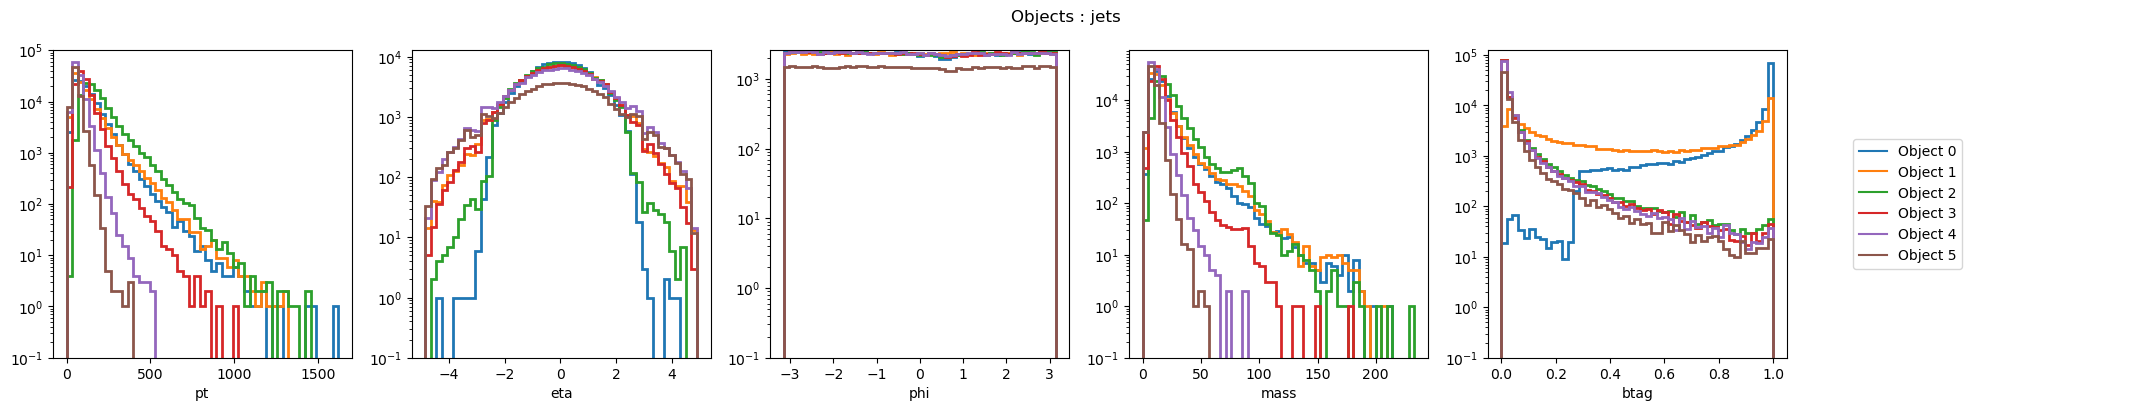

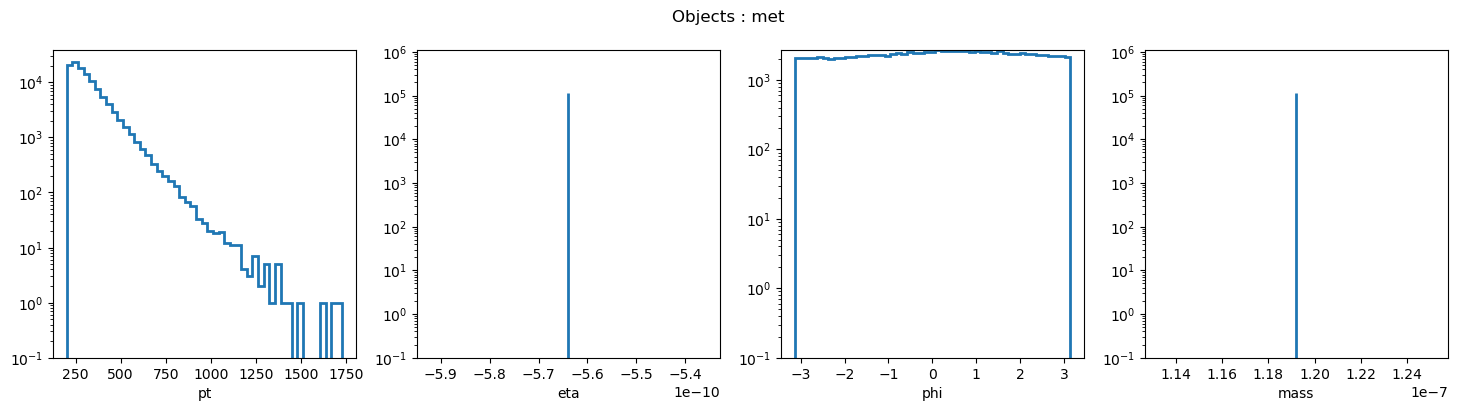

After preprocessing


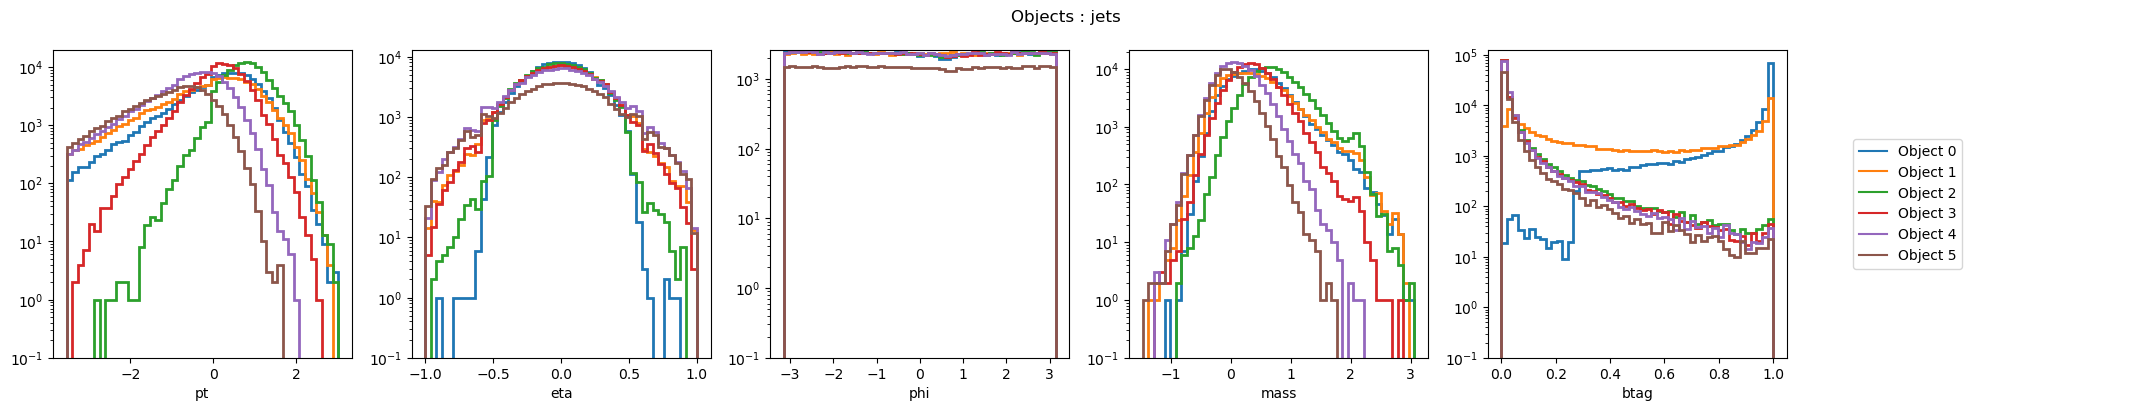

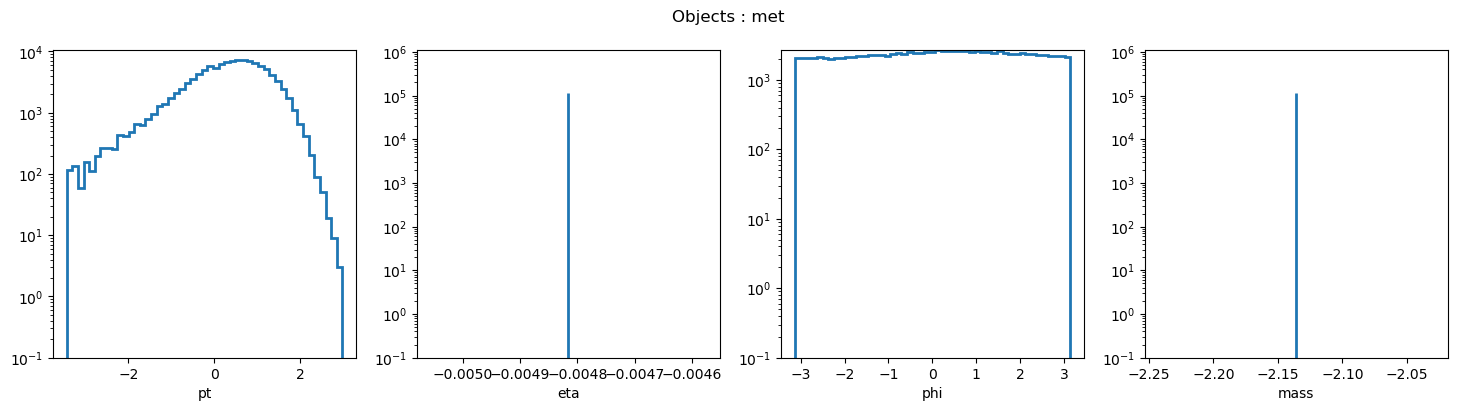

In [23]:
print ('Before preprocessing')
reco_dataset.plot(selection=True,raw=True,log=True)
print ('After preprocessing')
reco_dataset.plot(selection=True,raw=False,log=True)

# Combined dataset

In [ ]:
combined_dataset = CombinedDataset(
    hard_dataset=hard_dataset,
    reco_dataset=reco_dataset,
)
print(combined_dataset)

In [ ]:
inference_loader = DataLoader(
    combined_dataset,
    batch_size = 10000,
    shuffle = False,
    num_workers = num_workers,
    pin_memory = True,
)

In [ ]:
model = StandardCFM.load_from_checkpoint(checkpoint_path="trained_standardCFM/model_epoch_500.ckpt")
model.to(accelerator)
model.eval()

# TransferCFM

In [ ]:
batch = next(iter(inference_loader))
batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)

# Print the structure of the batch
print("Batch structure:")
for key in batch:
    print(f"{key}:")
    for sub_key, val in batch[key].items():
        if isinstance(val, list):
            print(f"  {sub_key}: {[v.shape for v in val]}")
        elif isinstance(val, torch.Tensor):
            print(f"  {sub_key}: {val.shape}")

traj_samples_file = "traj_samples.pt"
all_traj_file = "all_traj.pt"
if os.path.exists(os.path.join("saved_samples", traj_samples_file)) and os.path.exists(os.path.join("saved_samples", all_traj_file)):
    traj_samples = load_samples(traj_samples_file)
    all_traj = load_samples(all_traj_file)
else:
    with torch.no_grad():
        model = model.to(model.device)

        # Extract the necessary inputs for sampling
        hard_data = batch["hard"]["data"]
        hard_mask = batch["hard"]["mask"]
        reco_data = batch["reco"]["data"]
        reco_mask = batch["reco"]["mask"]

        print(f"Hard data batch size: {hard_data[0].shape[0]}")
        print(f"Reco data batch size: {reco_data[0].shape[0]}")

        traj_samples, all_traj = model.sample(
            hard_data,
            hard_mask,
            reco_data,
            reco_mask,
            N_sample=1000,
            steps=20,
            store_trajectories=True
        )
    save_samples(traj_samples, traj_samples_file)
    save_samples(all_traj, all_traj_file)
    # Took 12 mins for 100 samples

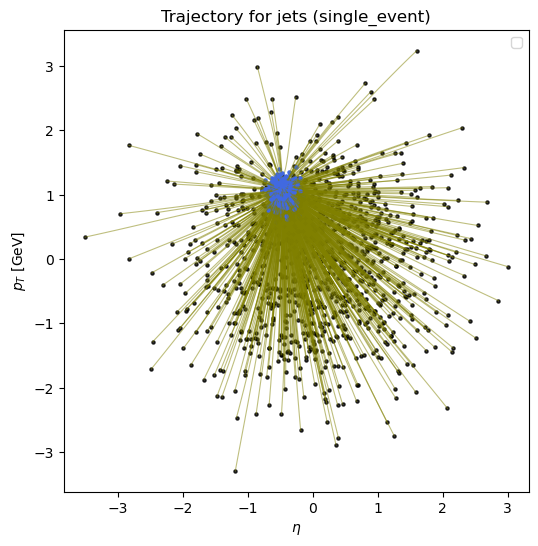

In [13]:
# all_traj is the shape [N_sample, steps+1, B, sum_reco, 2], used for 2D trajectory plots
# Feature indexes:
#   Jets: "pt"=0, "eta"=1 "phi"=2
#   MET: "pt"=0, "phi"=1
plot_trajectories_2d(
    all_traj,
    model,
    type_idx = 1, # "Jets"=0, "met"=1
    feat_idx_x = 1,
    feat_idx_y = 0,
    num_events = 100,
    mode = "single_event",
    event_idx = 1,
    object_idx = 0,
    #preprocessing = combined_dataset.reco_dataset.preprocessing,
    batch=batch,
)
plot_trajectories_2d(
    all_traj,
    model,
    type_idx = 0, # "Jets"=0, "met"=1
    feat_idx_x = 1,
    feat_idx_y = 0,
    num_events = 100,
    mode = "single_event",
    event_idx = 325,
    object_idx = 0,
    #preprocessing = combined_dataset.reco_dataset.preprocessing,
    batch=batch,
)

Selecting 500 out of 1000 to plot.


/software/sa21722/miniconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)


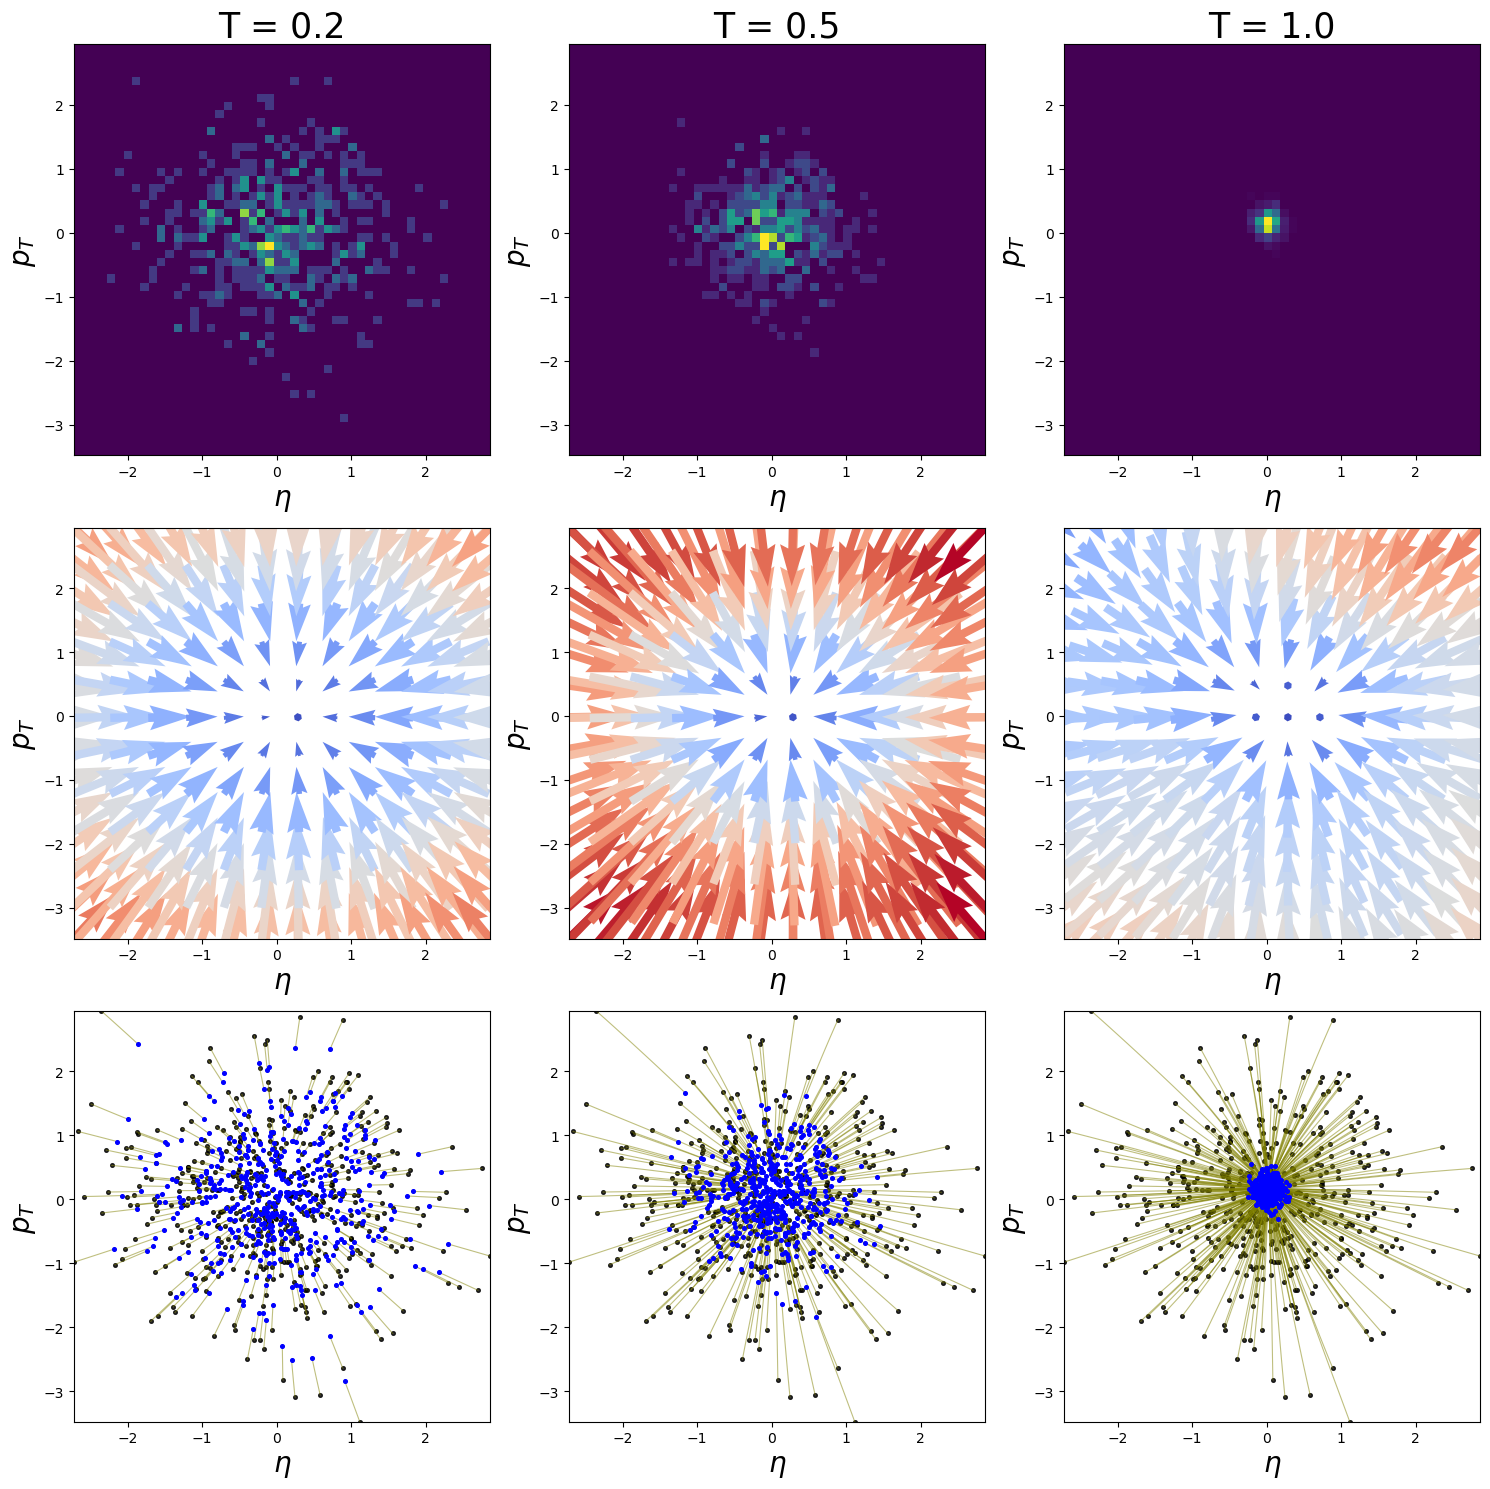

In [14]:
plot_trajectories_grid(
    all_traj,
    model,
    custom_timesteps=[4, 10, 20],
    type_idx=0,
    feat_idx_x=1,
    feat_idx_y=0,
    max_points=500,
    event_idx=57,
    object_idx=0,
    batch=batch,
    grid_size=14
)

In [15]:
samples_full_file = "samples_full.pt"
full_traj_file = "full_traj.pt"

if os.path.exists(os.path.join("saved_samples", samples_full_file)) and os.path.exists(os.path.join("saved_samples", full_traj_file)):
    samples_full = load_samples(samples_full_file)
    full_traj = load_samples(full_traj_file)
else:
    # Use a DataLoader with batch_size=10 for testing (change as needed)
    full_loader = DataLoader(
        combined_dataset,
        batch_size=1000,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
    )

    # Lists to accumulate outputs from each mini-batch
    samples_full_list = []
    full_traj_list = []

    with torch.no_grad():
        # Use enumerate to get the batch index along with the batch
        for batch_idx, batch in enumerate(tqdm(full_loader, desc="Processing full dataset")):

            # Move the batch to the appropriate device
            batch = CFMSamplingCallback.move_batch_to_device(batch, model.device)
            
            # Extract inputs for the sampling function
            hard_data = batch["hard"]["data"]
            hard_mask = batch["hard"]["mask"]
            reco_data = batch["reco"]["data"]
            reco_mask = batch["reco"]["mask"]
            
            # Run model sampling on the current batch
            samples_full, full_traj = model.sample(
                hard_data,
                hard_mask,
                reco_data,
                reco_mask,
                N_sample=100,      # number of samples per event
                steps=20,
                store_trajectories=True
            )
            
            # Append outputs from this batch (each is a list of tensors)
            samples_full_list.append(samples_full)
            full_traj_list.append(full_traj)

    # Determine the number of elements per sample (assuming it's consistent across batches)
    num_items = len(samples_full_list[0])

    # Concatenate corresponding elements across batches along the batch dimension (dim=2)
    samples_full = [
        torch.cat([batch_output[i] for batch_output in samples_full_list], dim=1)
        for i in range(num_items)
    ]
    full_traj = [
        torch.cat([batch_output[i] for batch_output in full_traj_list], dim=1)
        for i in range(num_items)
    ]

    # Save the concatenated results
    save_samples(samples_full, "samples_full.pt")
    save_samples(full_traj, "full_traj.pt")

Samples loaded from saved_samples/samples_full.pt
Samples loaded from saved_samples/full_traj.pt


/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:131: RuntimeWarning: invalid value encountered in divide
  gen_counts, _ = np.histogram(gen_vals, bins=bins)
/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:132: RuntimeWarning: invalid value encountered in divide
  bin_widths = np.diff(bins)


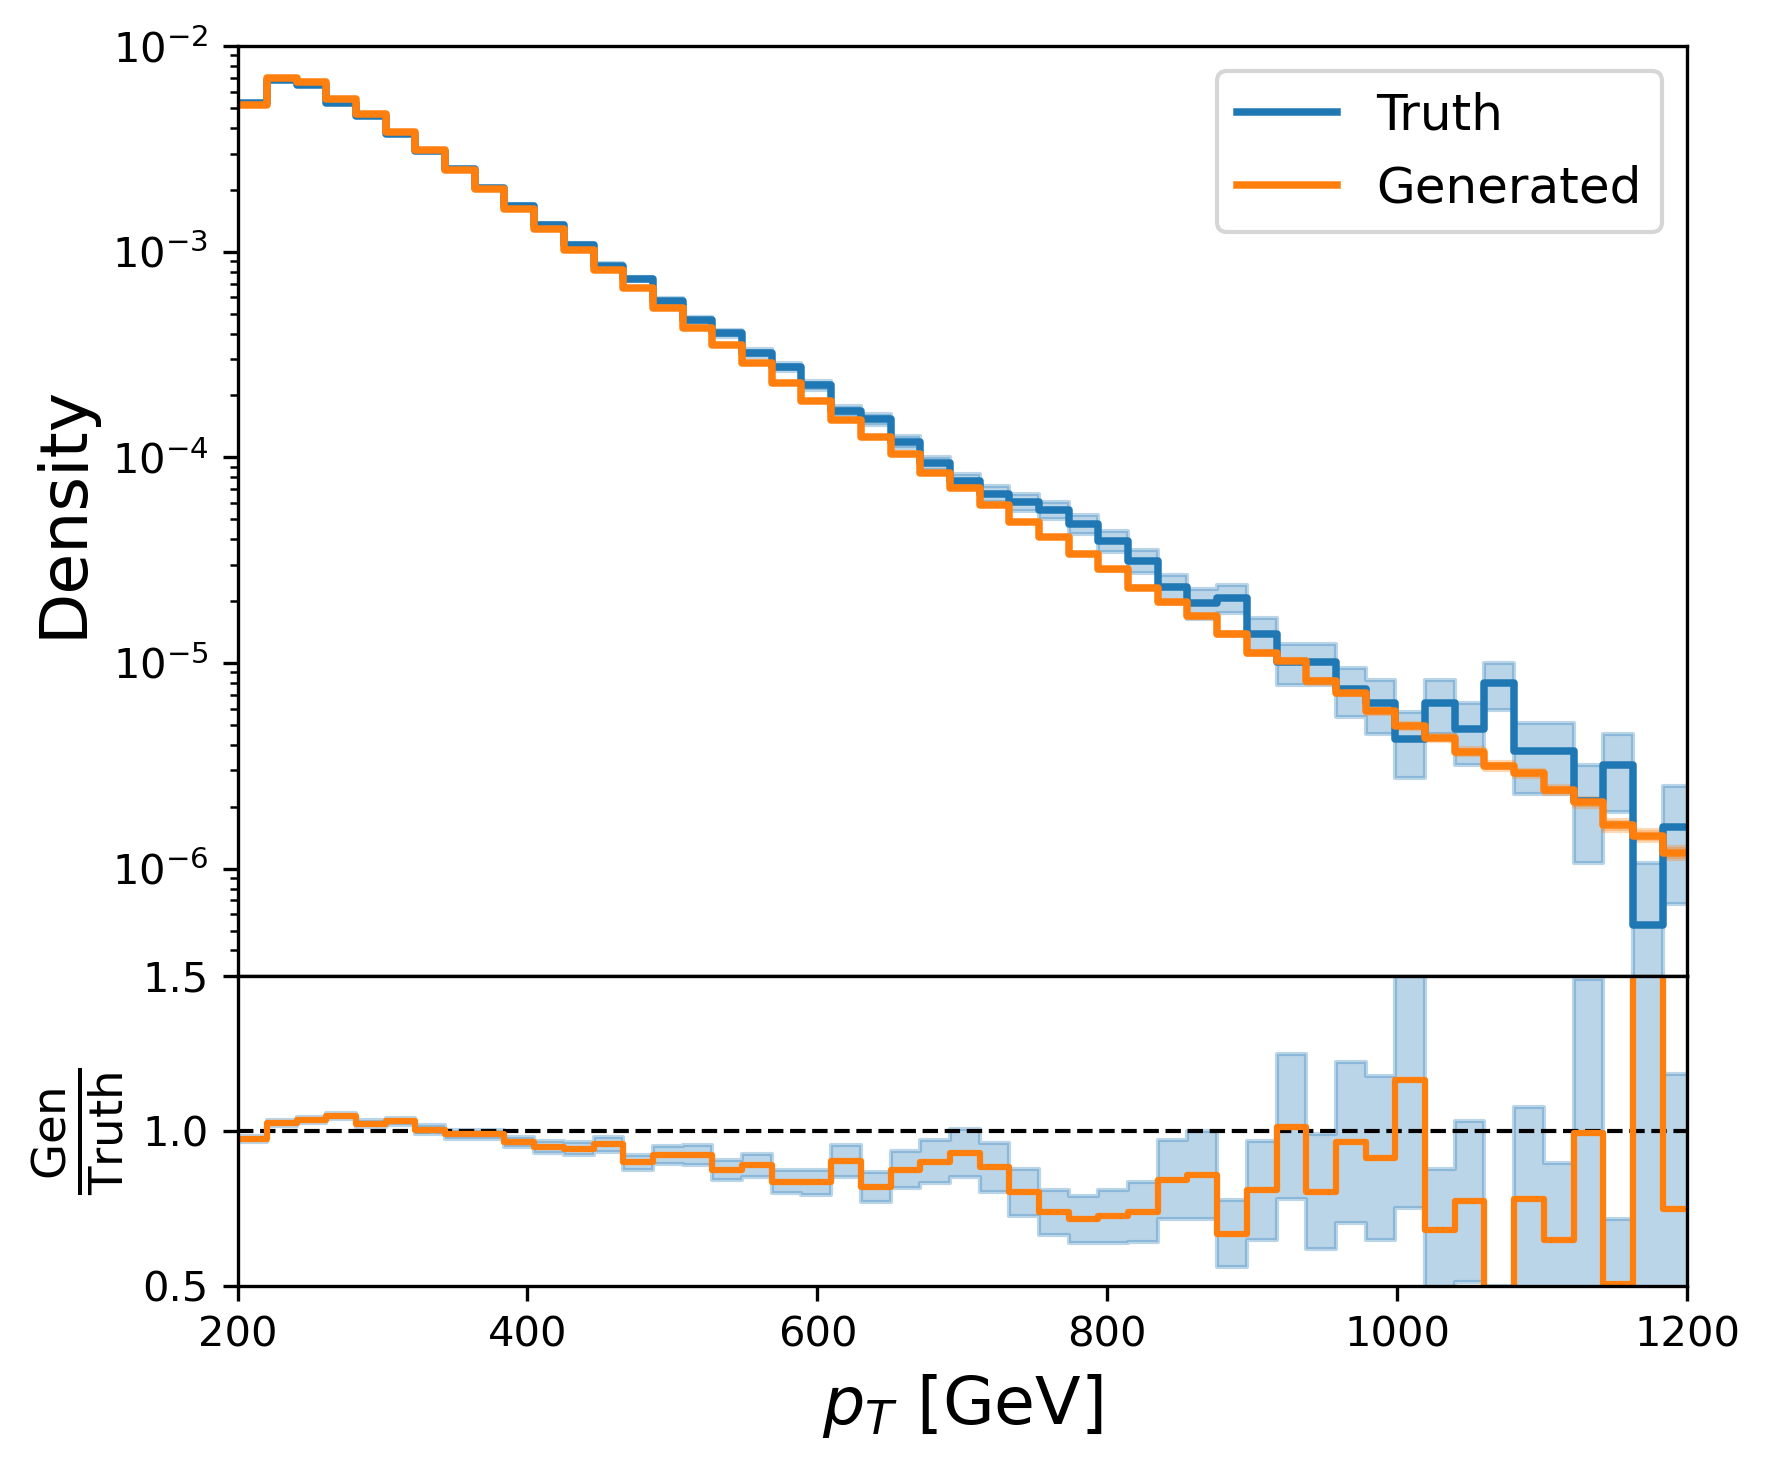

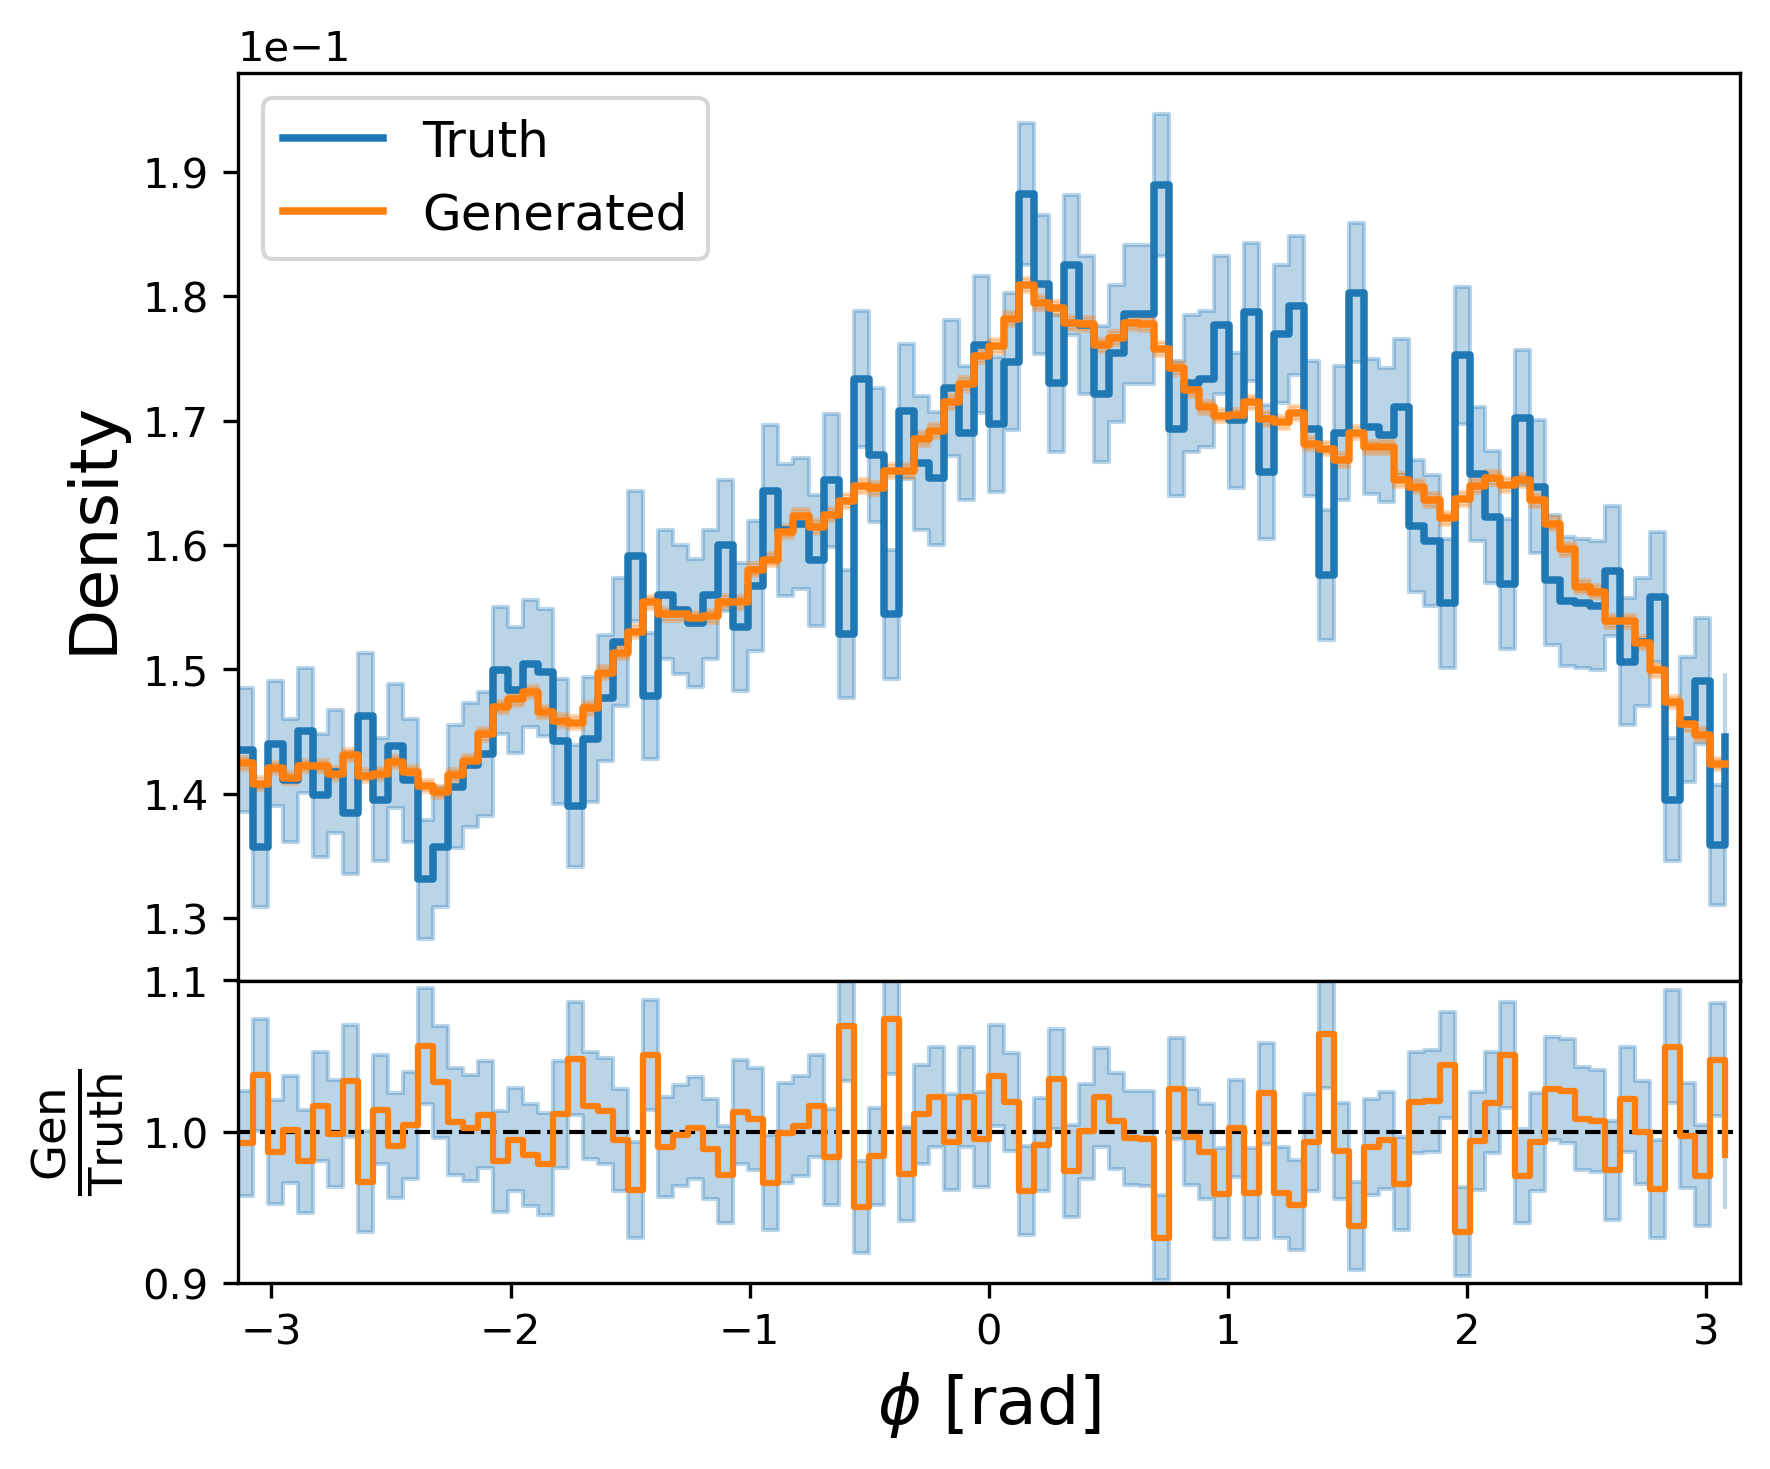

/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:131: RuntimeWarning: invalid value encountered in divide
  gen_counts, _ = np.histogram(gen_vals, bins=bins)
/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:132: RuntimeWarning: invalid value encountered in divide
  bin_widths = np.diff(bins)


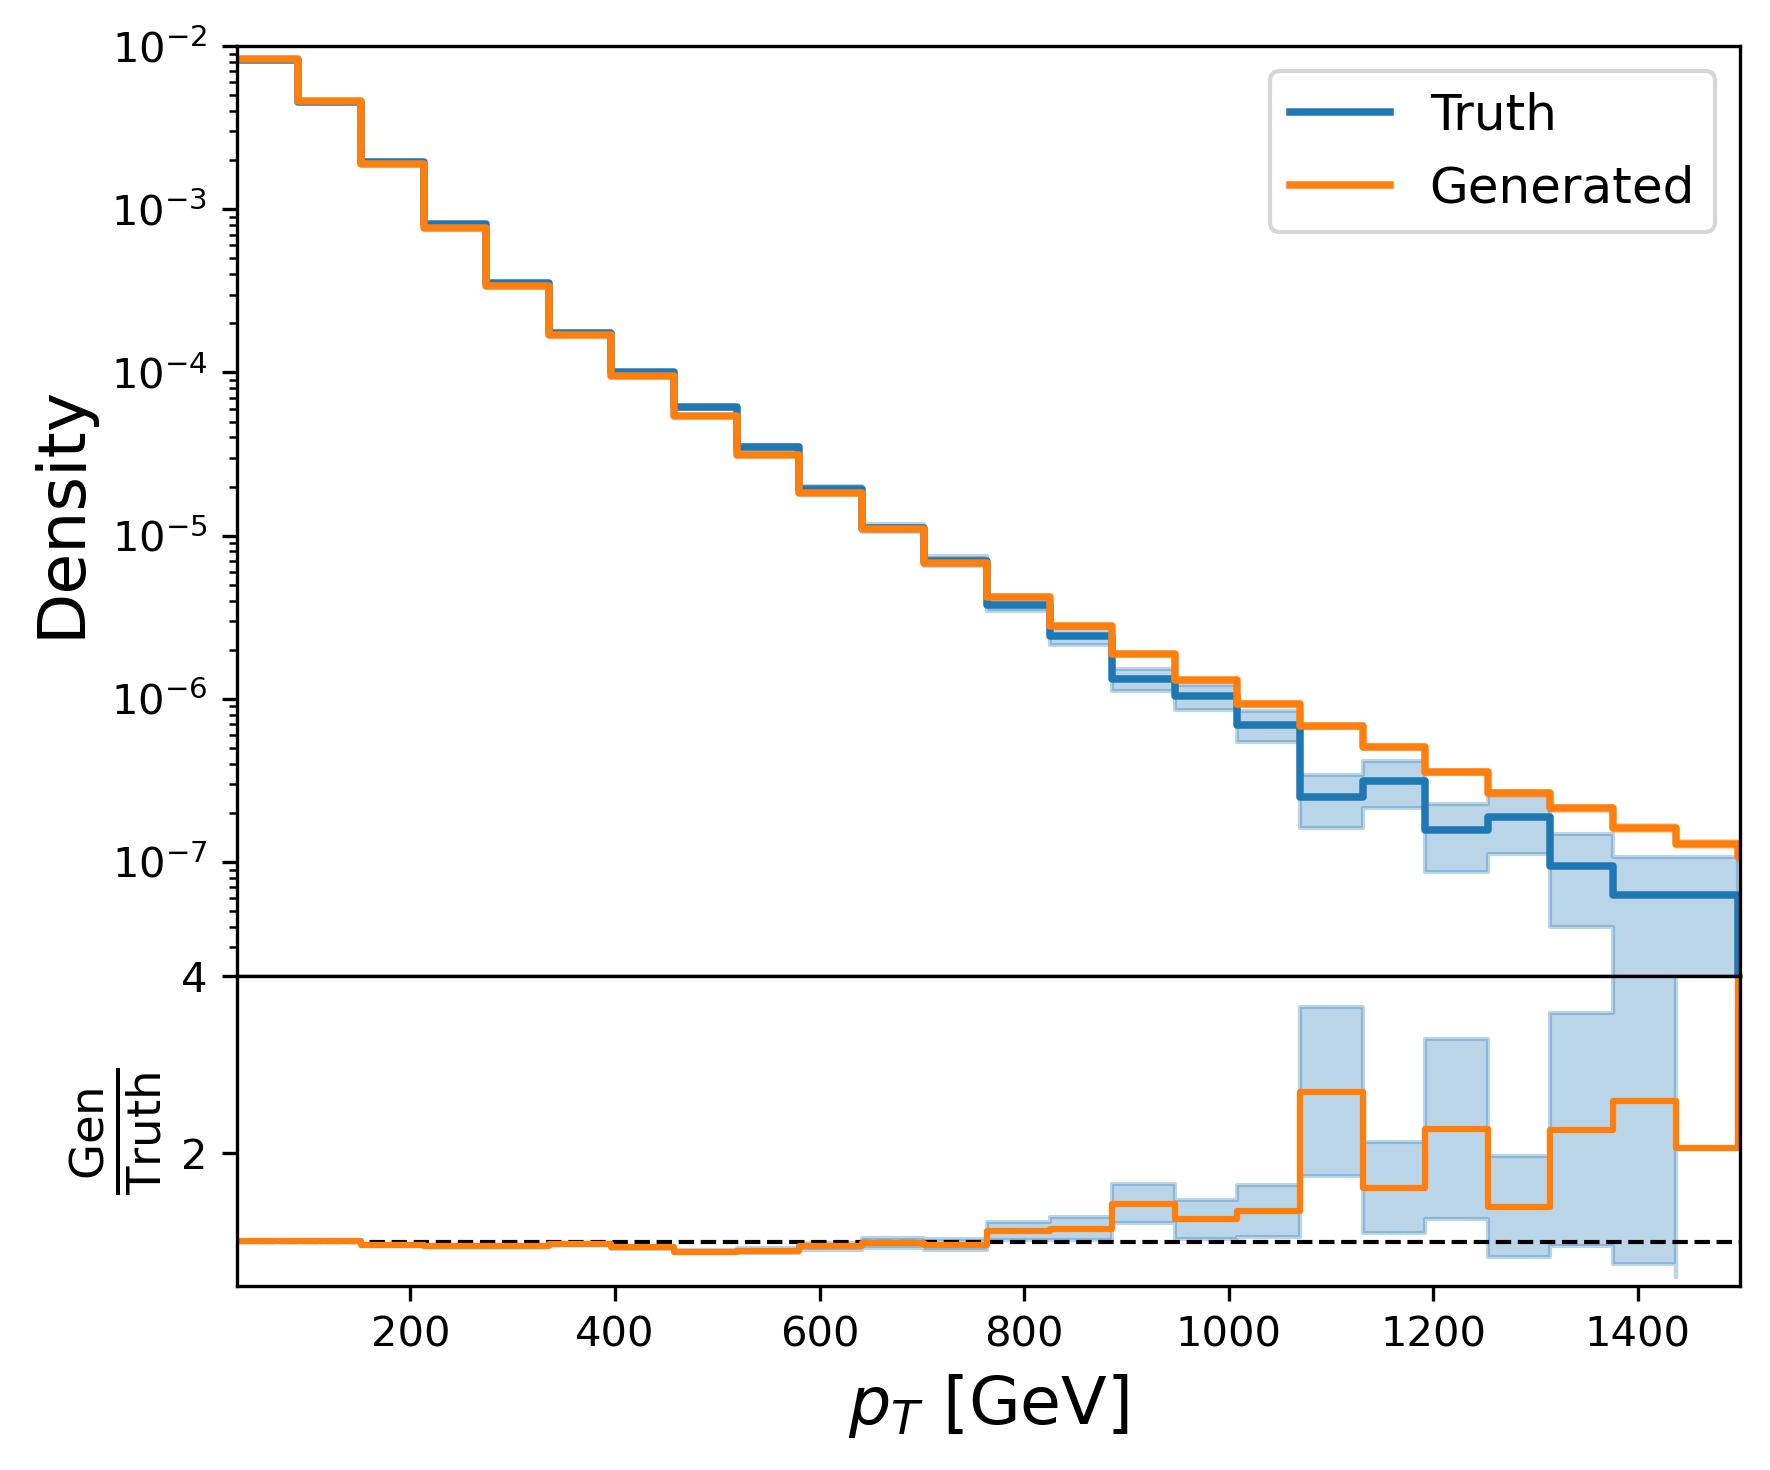

/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:131: RuntimeWarning: invalid value encountered in divide
  gen_counts, _ = np.histogram(gen_vals, bins=bins)
/cephfs/dice/users/sa21722/projects/MEM/memflow/ttH/models/utils.py:132: RuntimeWarning: invalid value encountered in divide
  bin_widths = np.diff(bins)


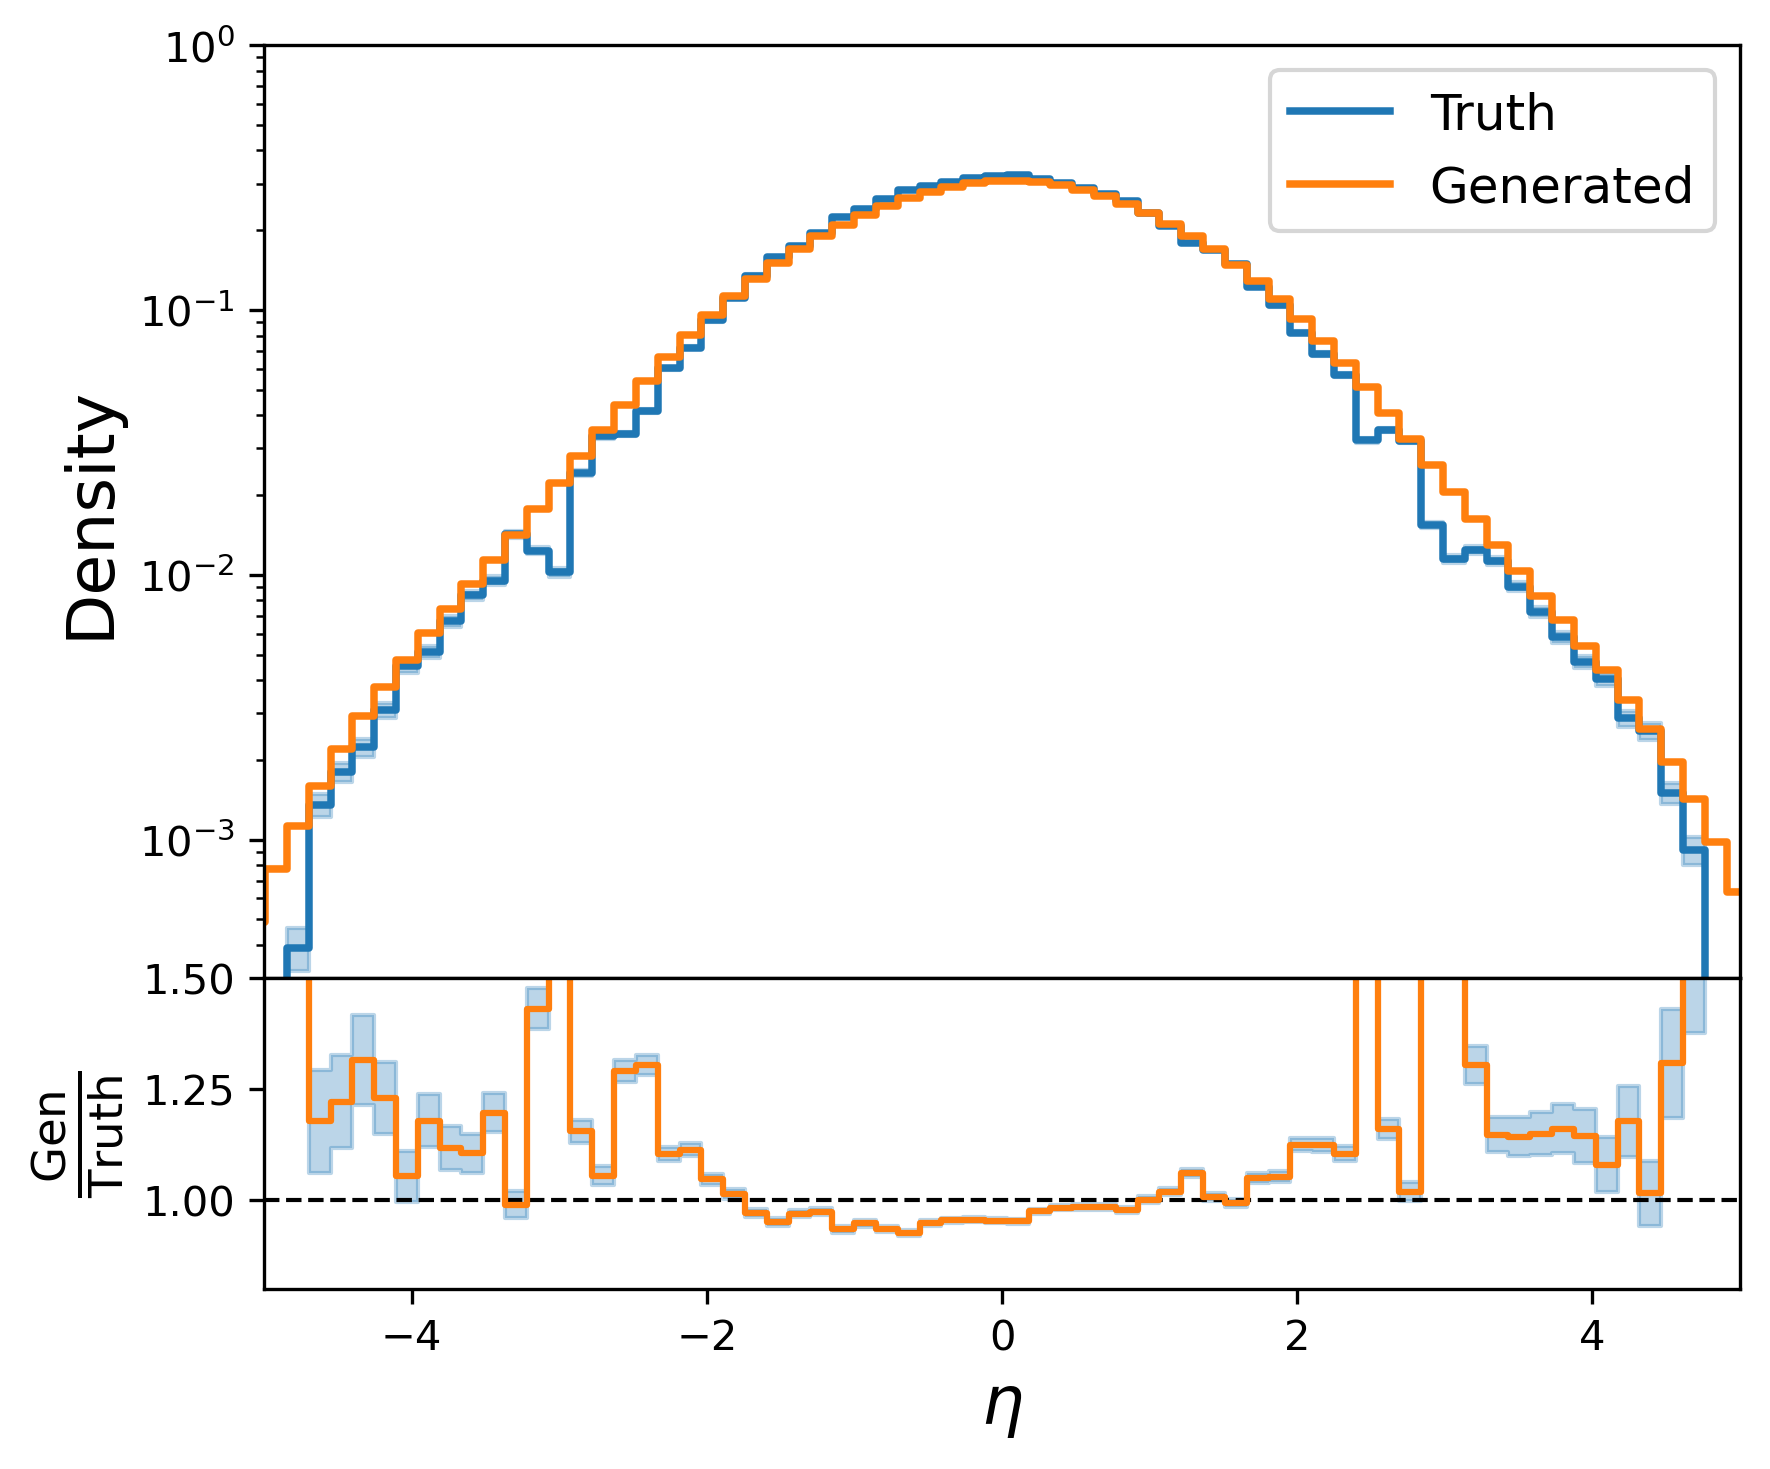

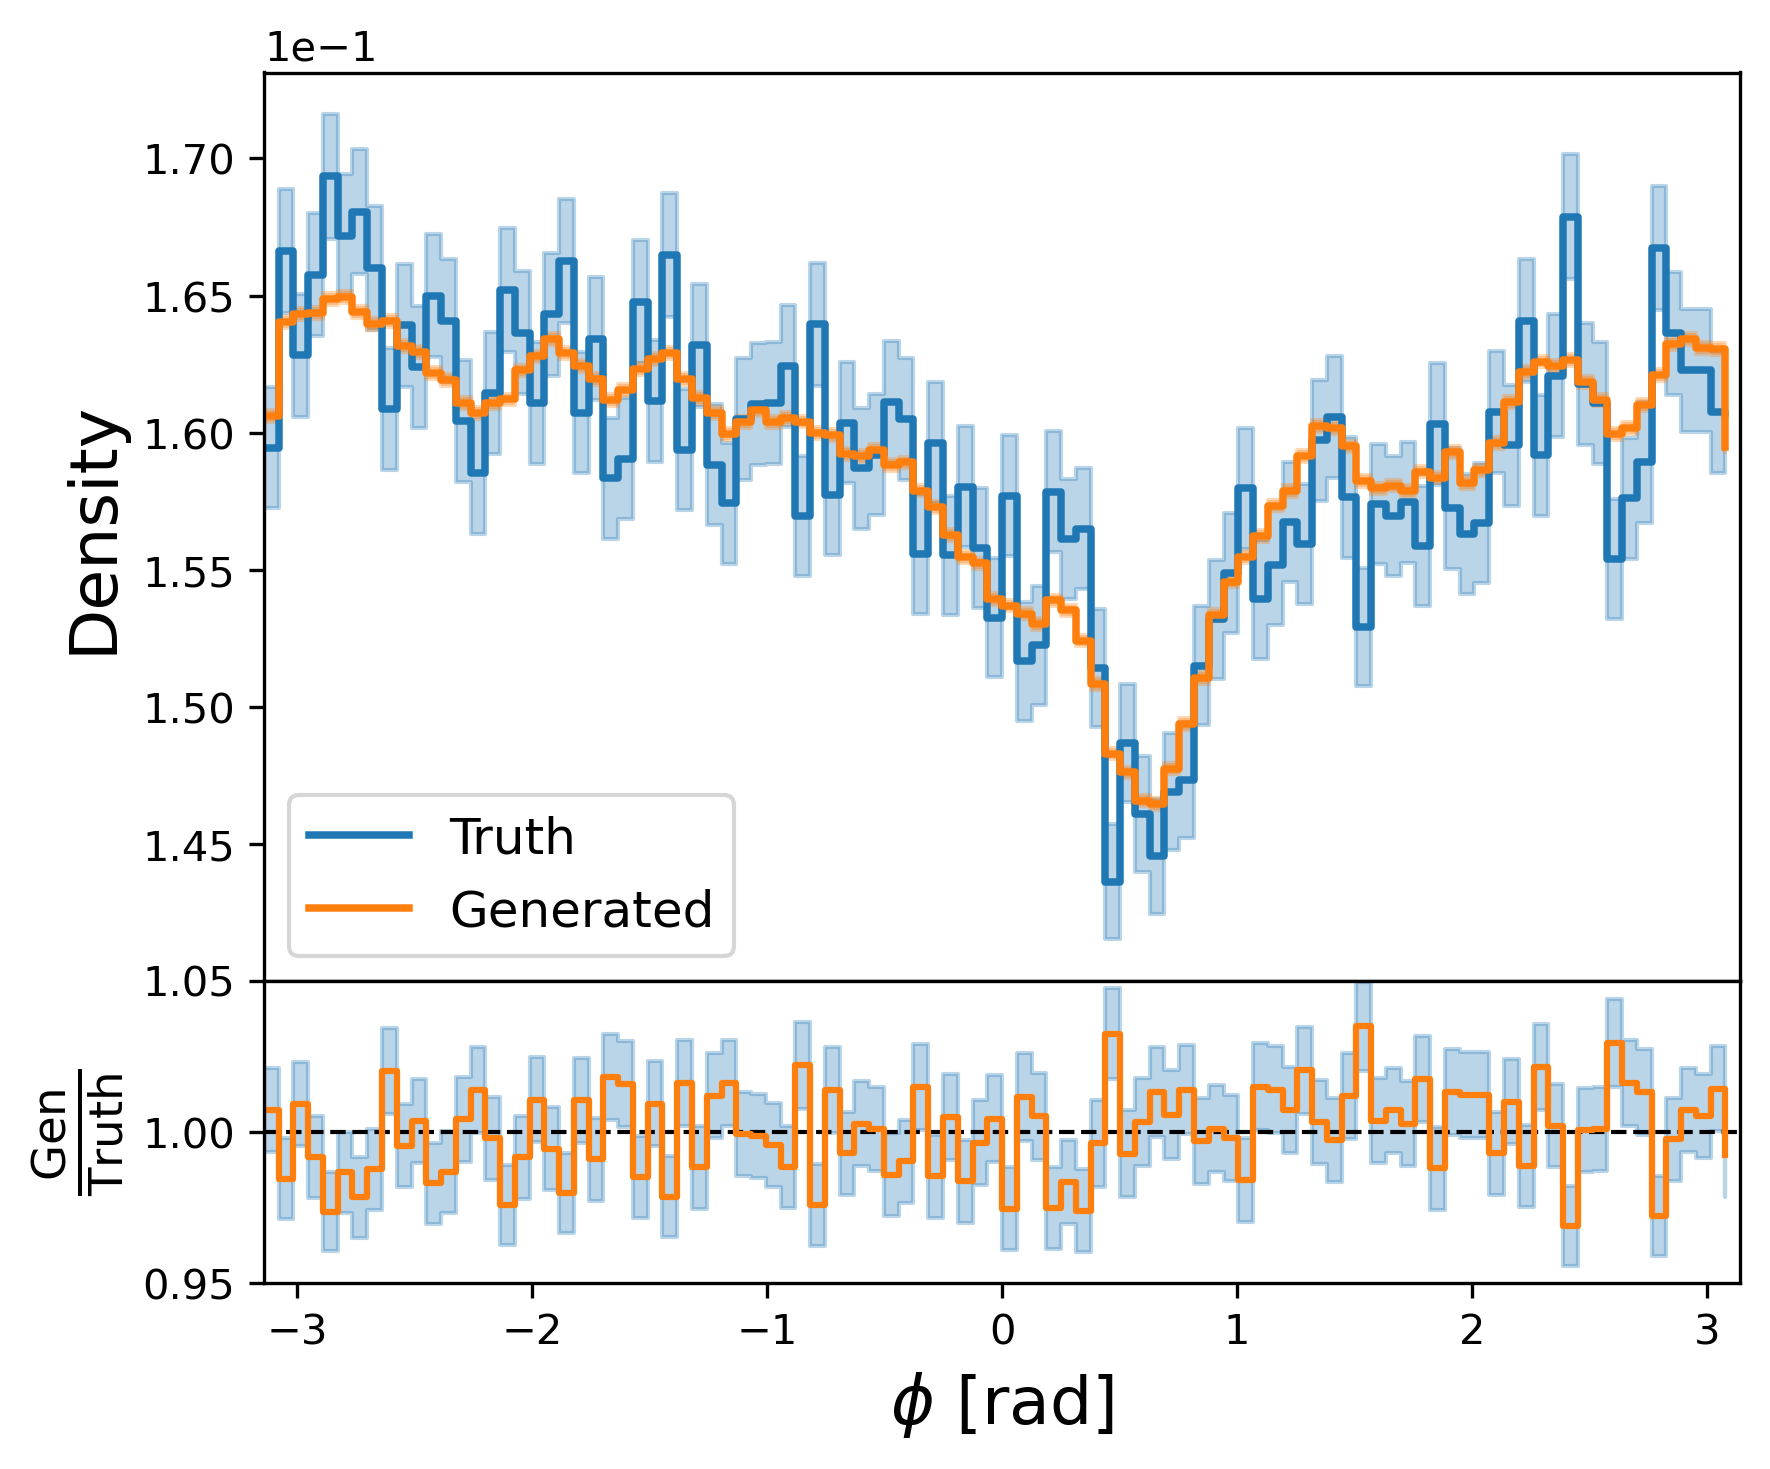

In [70]:
full_loader = DataLoader(
    combined_dataset,
    batch_size = 91819,
    shuffle = False,
    num_workers = 0,
    pin_memory = True,
)

full_batch = next(iter(full_loader))
full_batch = CFMSamplingCallback.move_batch_to_device(full_batch, model.device)

# Get the reco mask for the same index.
real_data_full = full_batch["reco"]["data"]
real_mask_full = full_batch["reco"]["mask"]

# ========== MET ==========
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=1,
                                 feat_idx=0,
                                 feat_name=r"$p_T$ [GeV]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=1,
                                 feat_idx=1,
                                 feat_name=r"$\phi$ [rad]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 nbins=100)

# ========= JETS =========
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=0,
                                 feat_name=r"$p_T$ [GeV]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=1,
                                 feat_name=r"$\eta$",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 log_scale=True,
                                 nbins=100)
compare_distributions(model, real_data_full, samples_full,
                                 ptype_idx=0,
                                 feat_idx=2,
                                 feat_name=r"$\phi$ [rad]",
                                 preprocessing=combined_dataset.reco_dataset.preprocessing,
                                 real_mask=real_mask_full,
                                 nbins=100)

In [ ]:
# Callbacks to make plots within comet
bias = BiasCallback(
    dataset = combined_dataset,               # dataset on which to evaluate bias
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline to draw raw variables
    N_sample = 100, #100                                # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                                 # plotting frequency (epochs)
    raw = True,
    bins = 101,                                      # 1D/2D plot number of bins
    points = 20,                                    # Number of points for the quantile
    log_scale = True,                               # log
    batch_size = 1000, #1000                         # Batch size to evaluate the dataset (internally makes a loaded)
    N_batch = 1,                                   # Stop after N batches (makes it faster)
    suffix = 'ttH',                                 # name for plots
    label_names = {                             # makes nicer labels
        'pt' : 'p_T',
        'eta' : '\eta',
        'phi' : '\phi',
    },
)

sampling = SamplingCallback(
    dataset = combined_dataset,           # dataset to check sampling
    preprocessing = combined_dataset.reco_dataset.preprocessing, # preprocessing pipeline
    idx_to_monitor = [1,2,3,4,5,6,7,8,9,10],               # idx of events in dataset to make plots with
    N_sample = 10000,                          # number of samples to draw
    steps = 20,                                     # Number of bridging steps
    store_trajectories = False,                     # To save trajectories plots
    frequency = 50,                             # plotting frequency (epochs)
    bins = 101,                                  # 1D/2D plot number of bins
    log_scale = True,                           # log
    label_names = {                             # makes nicer labels
        'pt' : r'$p_T$ [GeV]',
        'eta' : r'$\eta$',
        'phi' : r'$\phi$ [rad]',
    },
    pt_range = 500,
)

In [ ]:
samples_file = "samples.pt"
if os.path.exists(os.path.join("saved_samples", samples_file)):
    samples = load_samples(samples_file)
else:
    device = model.device
    sampling.set_idx(sampling.idx_to_monitor)
    hard_data = [d.to(device) for d in sampling.batch['hard']['data']]
    hard_mask = [m.to(device) for m in sampling.batch['hard']['mask']]
    reco_data = [d.to(device) for d in sampling.batch['reco']['data']]
    reco_mask = [m.to(device) for m in sampling.batch['reco']['mask']]

    print(f"Hard data batch size: {hard_data[0].shape[0]}")
    print(f"Reco data batch size: {reco_data[0].shape[0]}")

    with torch.no_grad():
        model = model.to(model.device)
        samples = model.sample(
                            hard_data, hard_mask,
                            reco_data, reco_mask,
                            sampling.N_sample,
                            sampling.steps,
                            sampling.store_trajectories
                        )
    save_samples(samples, samples_file)

In [ ]:
figures = sampling.make_sampling_plots(model,show=True,external_samples=samples)

In [ ]:
device=model.device

bias_samples_file = "bias_samples.pt"
if os.path.exists(os.path.join("saved_samples", bias_samples_file)):
    bias_samples = load_samples(bias_samples_file)
else:
    for batch_idx, batch in tqdm(enumerate(bias.loader),desc='Predict',disable=False,leave=True,total=min(bias.N_batch,len(bias.loader)),position=0):
        if batch_idx >= bias.N_batch:
            break

        # Get parts #
        hard_data = [data.to(device) for data in batch['hard']['data']]
        hard_mask_exist = [mask.to(device) for mask in batch['hard']['mask']]
        reco_data = [data.to(device) for data in batch['reco']['data']]
        reco_mask_exist = [mask.to(device) for mask in batch['reco']['mask']]

        print(f"Hard data batch size: {hard_data[0].shape[0]}")
        print(f"Reco data batch size: {reco_data[0].shape[0]}")

        # Sample #
        with torch.no_grad():
            bias_samples = model.sample(
                hard_data, hard_mask_exist,
                reco_data, reco_mask_exist,
                bias.N_sample,
                bias.steps,
                bias.store_trajectories,
            )
        save_samples(bias_samples, bias_samples_file)

In [ ]:
figs = bias.make_bias_plots(model,show=True,external_samples=bias_samples)